In [1]:
"""
Created on Mon Feb 3 13:04:14 2024

@author: drsaq
"""

### Import required libraries
import tensorflow as tf
import os
import random
import numpy as np
import glob
import pickle
from tqdm import tqdm 
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# Divide the large image into 256 x 256 size of patches that is required to feed into model
def divide_into_patches(image, patch_size):
    height, width = image.shape[:2]
    patches = []
    
    # Calculate the number of patches in each dimension
    num_patches_x = (width + patch_size - 1) // patch_size
    num_patches_y = (height + patch_size - 1) // patch_size
    
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            # Calculate the coordinates for each patch
            left = x * patch_size
            upper = y * patch_size
            right = min(left + patch_size, width)
            lower = min(upper + patch_size, height)
            
            # Crop the patch from the original image
            patch = image[upper:lower, left:right]
            patches.append(patch)
    
    return patches

In [3]:
# After making predictions with all patches, this code will be merged to reconstruct large image
def reconstruct_from_patches(patches, original_size):
    height, width = original_size
    num_patches_x = (width + patch_size - 1) // patch_size
    num_patches_y = (height + patch_size - 1) // patch_size
    
    # Create an empty image with the original size
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    patch_index = 0
    for y in range(num_patches_y):
        for x in range(num_patches_x):
            # Calculate the coordinates to paste each patch
            left = x * patch_size
            upper = y * patch_size
            right = min(left + patch_size, width)
            lower = min(upper + patch_size, height)
            
            
            # Get the current patch
            patch = patches[patch_index]
            patch_height = lower - upper
            patch_width = right - left
            patch = patch[:patch_height, :patch_width]
            
            
            # Paste the patch onto the new image
            new_image[upper:lower, left:right] = patch
            
            patch_index += 1
    
    return new_image

In [4]:
# Load the model architecture
model = load_model("model_architecture.h5")

# Load the weights
model.load_weights('spore_test_dec5.hdf5')



In [8]:
# Read input from the device ( Just give the path of the input image)
#original_img = cv2.imread('C:/Users/drsaq/OneDrive/Desktop/256_paches/0min.jpg', 0)
original_img = Image.open('Image/0min.jpg').convert('L')
# Get the height, width of the input image
width, height = original_img.size

# Get a new height and width which are divisible by 256
new_height = (height // 256) * 256 
new_width = (width // 256) * 256

In [11]:
# Determine the desired image size based on the width of the input image

if 50 < width <= 512:  
    
   # Resize the test image into the model input shape
    test_img_other = original_img.resize((256, 256))
    test_img_other = np.array(test_img_other) 
   # Extend the dimension to match the model size 
    t_img_other = np.expand_dims(test_img_other, axis=-1)
    t_img_other = np.expand_dims(t_img_other, 0)

    # Make a prediction
    prediction_other = (model.predict(t_img_other)[0, :, :, 0] > 0.5).astype(np.uint8)
    # Save the prediction
    cv2.imwrite("Result/prediction.jpg", prediction_other)

else:

    large_image = original_img.resize((new_width, new_height))
    patch_size = 256
    predicted_patches = []
    # Divide the large image into patches
    patches = divide_into_patches(large_image, patch_size)

    for patch in patches:
        patch = np.expand_dims(patch, axis=-1)
    #patch = np.expand_dims(normalize(np.array(patch), axis=1),2)
        patch = np.expand_dims(patch, 0)
        img = (model.predict(patch)[0,:,:,0] > 0.5).astype(np.uint8)
        predicted_patches.append(img)

    prediction_other = reconstruct_from_patches( predicted_patches, large_image.shape[:2])
    cv2.imwrite("Result/large_prediction1.jpg", prediction_other)


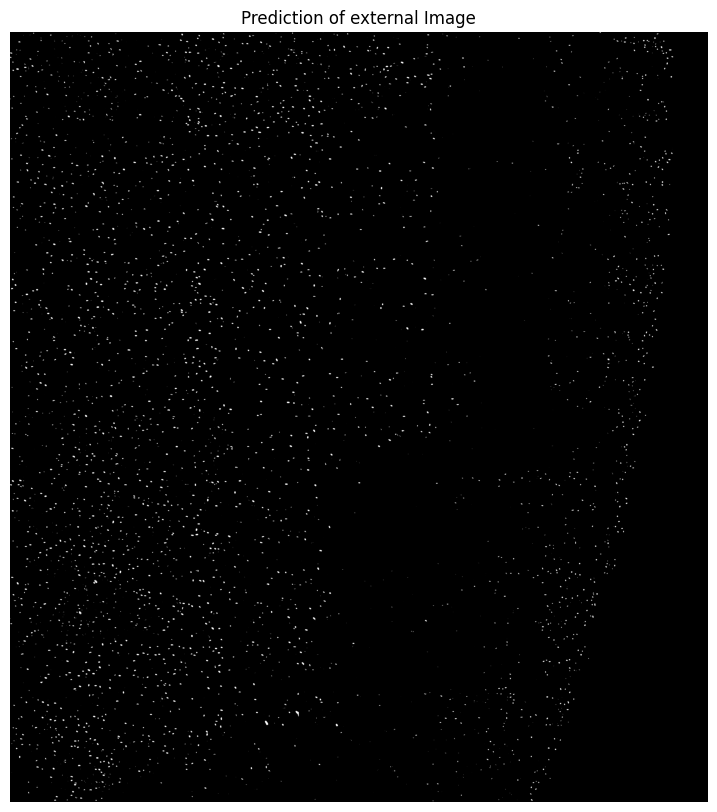

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))  # Set figure size to 10x10 inches
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.axis('off')
plt.show()